##Importing

In [22]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from random import shuffle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [23]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [25]:
path_root  = '/content/gdrive/MyDrive/malimg_imgs'

To be able to use our images for training and testing, lets use ImageDataGenerator.flow_from_directory() which generates batches of normalized tensor image data from the respective data directories.

target_size : Will resize all images to the specified size. I personally chose (64*64) images.
batch_size : Is the size of the batch we will use. In our case, we only have 9339 images, hence setting a batch_size above this won't change anything.

In [26]:
from keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64,64), batch_size=10000)

Found 9683 images belonging to 25 classes.


In [27]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

Batches generated with ImageDataGenerator() is an iterator. Hence, we use next() to go through all its elements and generate a batch of images and labels from the data set.

In [28]:
imgs, labels = next(batches)

As you can see, our images are in RGB with shape 64x64 [width x length x depth].

In [29]:
imgs.shape

(9683, 64, 64, 3)

Labels has the shape (batch_size, number of classes).

In [30]:
labels.shape

(9683, 25)

The following method allows us to plot a sample of images in our dataset.

In [31]:
# plots images with labels within jupyter notebook
import matplotlib.pyplot as plt
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
  if type(ims[0]) is np.ndarray:
      ims = np.array(ims).astype(np.uint8)
      if (ims.shape[-1] != 3):
        ims = ims.transpose((0,2,3,1))
  f = plt.figure(figsize=figsize)
  cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
  for i in range(0,50):
      sp = f.add_subplot(rows, cols, i+1)
      sp.axis('Off')
      if titles is not None:
          sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
      plt.imshow(ims[i], interpolation=None if interp else 'none')

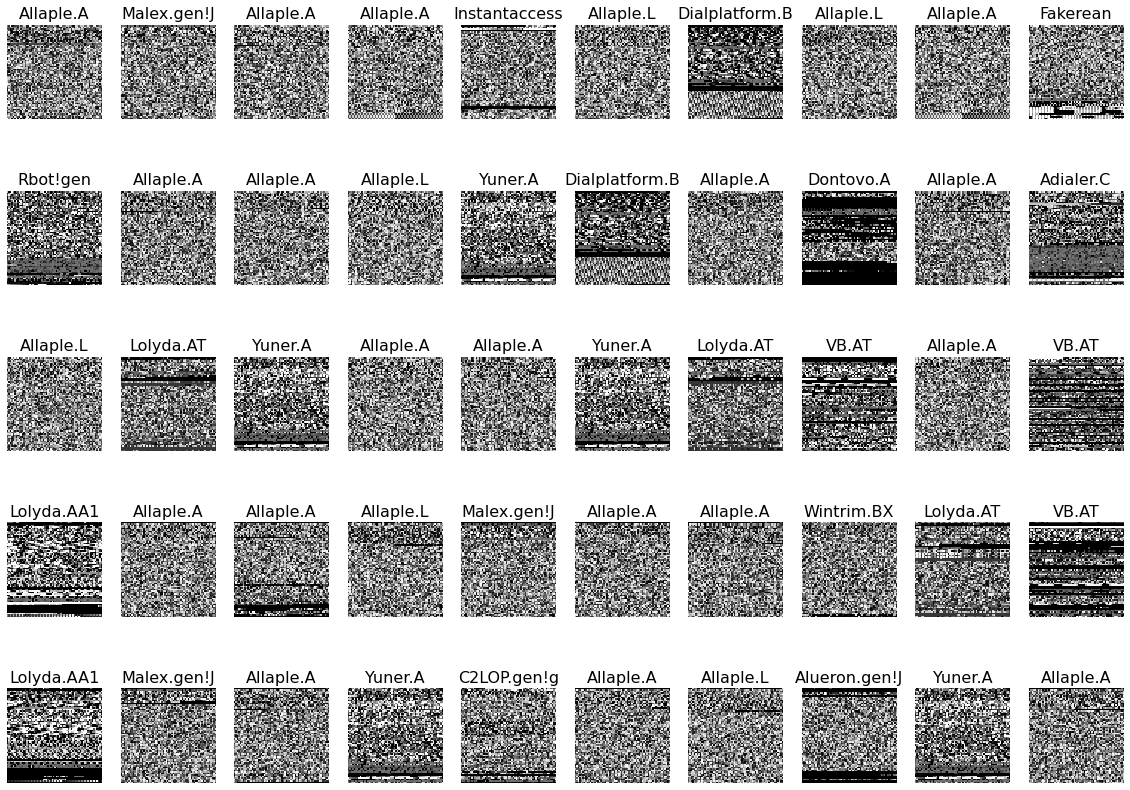

In [24]:
plots(imgs, titles = labels)

We can already observe differences between classes.

##Analyze

All our images are finally ready to be used. Lets check out the repartition of data between classes :

In [32]:
classes = batches.class_indices.keys()

In [33]:
perc = (sum(labels)/labels.shape[0])*100

<BarContainer object of 25 artists>

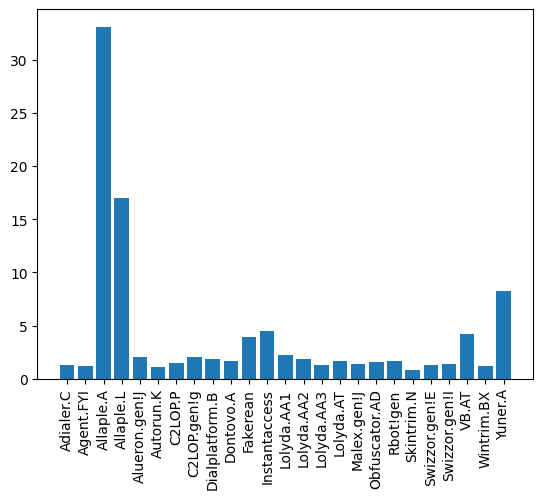

In [34]:
plt.xticks(rotation='vertical')
plt.bar(classes,perc)

##Train And Test


Lets split our model into train and test following a ratio 70% train - 30% test ratio.

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [36]:
X_train.shape

(6778, 64, 64, 3)

In [37]:
X_test.shape

(2905, 64, 64, 3)

In [38]:
y_train.shape

(6778, 25)

In [39]:
y_test.shape

(2905, 25)

##Convolutional Neural Network Model

We will now build our **CNN** model using Keras. This model will have the following layers :

**Convolutional Laye**r : 30 filters, (3 * 3) kernel size

**Max Pooling Layer** : (2 * 2) pool size

**Convolutional Layer** : 15 filters, (3 * 3) kernel size

**Max Pooling Layer** : (2 * 2) pool size

**DropOut Layer** : Dropping 25% of neurons.

**Flatten Layer**

**Dense/Fully Connected Layer** : 128 Neurons, Relu activation function

**DropOut Layer** : Dropping 50% of neurons.

**Dense/Fully Connected Layer** : 50 Neurons, Softmax activation function

**Dense/Fully Connected Layer** : num_class Neurons, Softmax activation 
function

**Input shape** : 64 * 64 * 3

In [ ]:
!pip install tensorflow keras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.0 MB/s eta 0:00:00
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 KB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 KB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 26.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0


In [40]:
#import keras

#!pip install tensorflow
import tensorflow 
#!pip install keras --upgrade
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
#from tensorflow.keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization


We want 25 classes as output.

In [41]:
num_classes = 25

In [42]:
def malware_model(ac):
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),activation=ac,input_shape=(64,64,3)))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation=ac))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation=ac))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation=ac))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

**We will compare with 10 different activation function**
    
    1. Sigmoid Function

    2.Tanh Function

    3.Leaky ReLU

    4.Exponential Linear Unit (ELU)

    5.Scaled Exponential Linear Unit (SELU)

    6.Gaussian Error Linear Unit (GELU)

    7.Swish

    8.Parametric ReLU

    9.Softplus


##Relu Function

In [43]:
Malware_model = malware_model('relu')

In [44]:
Malware_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 30)        840       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 30)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 15)        4065      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 15)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 15)        0         
                                                                 
 flatten_1 (Flatten)         (None, 2940)             

Several methods are available to deal with unbalanced data. I our case, I chose to give higher weight to minority class and lower weight to majority class.

class_weights uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. To use this method, y_train must not be one hot encoded.

In [45]:
y_train.shape

(6778, 25)

class_weight function cannot deal with one hot encoded y. We need to convert it.

In [46]:
y_train_new = np.argmax(y_train, axis=1)

In [47]:
y_train_new

array([ 5, 24,  2, ..., 15, 10,  2])

In [48]:
!pip install sklearn --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2955 sha256=6c602e3f5d7e1f0b6cc9e6b72b4c4d352ed25db4bbac65833cd70b989b857a55
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn


In [51]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train_new),y=y_train_new)

In [52]:
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
212/212 [==============================] - 34s 155ms/step - loss: 1.6651 - accuracy: 0.5043 - val_loss: 0.7644 - val_accuracy: 0.6971
Epoch 2/10
212/212 [==============================] - 34s 160ms/step - loss: 0.6958 - accuracy: 0.7752 - val_loss: 0.3278 - val_accuracy: 0.9071
Epoch 3/10
212/212 [==============================] - 32s 152ms/step - loss: 0.4017 - accuracy: 0.8808 - val_loss: 0.2330 - val_accuracy: 0.9373
Epoch 4/10
212/212 [==============================] - 34s 159ms/step - loss: 0.2947 - accuracy: 0.9088 - val_loss: 0.1866 - val_accuracy: 0.9477
Epoch 5/10
212/212 [==============================] - 35s 163ms/step - loss: 0.2296 - accuracy: 0.9287 - val_loss: 0.1582 - val_accuracy: 0.9556
Epoch 6/10
212/212 [==============================] - 33s 157ms/step - loss: 0.2017 - accuracy: 0.9363 - val_loss: 0.1513 - val_accuracy: 0.9556
Epoch 7/10
212/212 [==============================] - 32s 150ms/step - loss: 0.1709 - accuracy: 0.9439 - val_loss: 0.1598 - val_ac

In [53]:
scores = Malware_model.evaluate(X_test, y_test)

91/91 [==============================] - 3s 34ms/step - loss: 0.1262 - accuracy: 0.9635


We got a **96%** accuracy which is not bad !

In [54]:
print('Final CNN accuracy using Relu: ', scores[1])

Final CNN accuracy using Relu:  0.9635111689567566


In [55]:
dic={}
dic['Relu']=0.9635111689567566

In [1]:
acti_list=['sigmoid','tanh','selu','elu','gelu','swish','mish']


##Sigmoid Activation Function

In [96]:
print("---------------------------------Model using activation function: Sigmoid  ---------------------------------")

---------------------------------Model using activation function: Sigmoid  ---------------------------------


In [98]:
Malware_model = malware_model('sigmoid')


In [58]:
y_train_new = np.argmax(y_train, axis=1)

In [59]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train_new),y=y_train_new)

In [60]:
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
212/212 [==============================] - 47s 213ms/step - loss: 2.5228 - accuracy: 0.3302 - val_loss: 2.4802 - val_accuracy: 0.3287
Epoch 2/10
212/212 [==============================] - 37s 175ms/step - loss: 2.4939 - accuracy: 0.3318 - val_loss: 2.4828 - val_accuracy: 0.3287
Epoch 3/10
212/212 [==============================] - 38s 180ms/step - loss: 2.4921 - accuracy: 0.3321 - val_loss: 2.4771 - val_accuracy: 0.3287
Epoch 4/10
212/212 [==============================] - 35s 166ms/step - loss: 2.4937 - accuracy: 0.3320 - val_loss: 2.4795 - val_accuracy: 0.3287
Epoch 5/10
212/212 [==============================] - 39s 184ms/step - loss: 2.4891 - accuracy: 0.3320 - val_loss: 2.4826 - val_accuracy: 0.3287
Epoch 6/10
212/212 [==============================] - 34s 162ms/step - loss: 2.4891 - accuracy: 0.3320 - val_loss: 2.4784 - val_accuracy: 0.3287
Epoch 7/10
212/212 [==============================] - 36s 172ms/step - loss: 2.4894 - accuracy: 0.3320 - val_loss: 2.4810 - val_ac

In [61]:
scores = Malware_model.evaluate(X_test, y_test)

91/91 [==============================] - 3s 34ms/step - loss: 2.4798 - accuracy: 0.3287


In [62]:
print('Final CNN accuracy using Sigmoid: ', scores[1])

Final CNN accuracy using Sigmoid:  0.3287435472011566


In [63]:
dic['Sigmoid']= 0.3287435472011566

##Leaky Relu

In [65]:
print("---------------------------------Model using activation function: Leaky Relu---------------------------------")

---------------------------------Model using activation function: Leaky Relu---------------------------------


In [66]:
import tensorflow as tf
Malware_model = Sequential()
Malware_model.add(Conv2D(30, kernel_size=(3, 3),activation=tf.keras.layers.LeakyReLU(alpha=0.1),input_shape=(64,64,3)))
Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
Malware_model.add(Conv2D(15, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
Malware_model.add(Dropout(0.25))
Malware_model.add(Flatten())
Malware_model.add(Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
Malware_model.add(Dropout(0.5))
Malware_model.add(Dense(50, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
Malware_model.add(Dense(num_classes, activation='softmax'))
Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
y_train_new = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train_new),y=y_train_new)
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
212/212 [==============================] - 52s 241ms/step - loss: 1.4768 - accuracy: 0.5586 - val_loss: 0.6143 - val_accuracy: 0.8096
Epoch 2/10
212/212 [==============================] - 36s 169ms/step - loss: 0.5084 - accuracy: 0.8420 - val_loss: 0.2450 - val_accuracy: 0.9287
Epoch 3/10
212/212 [==============================] - 38s 182ms/step - loss: 0.2789 - accuracy: 0.9132 - val_loss: 0.1860 - val_accuracy: 0.9508
Epoch 4/10
212/212 [==============================] - 35s 166ms/step - loss: 0.1928 - accuracy: 0.9392 - val_loss: 0.1539 - val_accuracy: 0.9597
Epoch 5/10
212/212 [==============================] - 37s 175ms/step - loss: 0.1621 - accuracy: 0.9501 - val_loss: 0.1358 - val_accuracy: 0.9590
Epoch 6/10
212/212 [==============================] - 55s 262ms/step - loss: 0.1262 - accuracy: 0.9593 - val_loss: 0.1269 - val_accuracy: 0.9666
Epoch 7/10
212/212 [==============================] - 41s 192ms/step - loss: 0.1146 - accuracy: 0.9619 - val_loss: 0.1389 - val_ac

In [67]:
scores = Malware_model.evaluate(X_test, y_test)

91/91 [==============================] - 4s 44ms/step - loss: 0.1267 - accuracy: 0.9673


In [68]:
print('Final CNN accuracy using Leaky Relu: ', scores[1])

Final CNN accuracy using Leaky Relu:  0.9672977328300476


In [69]:
dic['Leaky Relu']=0.9672977328300476

## Soft plus

In [70]:
print("---------------------------------Model using activation function: Soft Plus---------------------------------")

---------------------------------Model using activation function: Soft Plus---------------------------------


In [71]:

Malware_model = Sequential()
Malware_model.add(Conv2D(30, kernel_size=(3, 3),activation=tf.nn.softplus,input_shape=(64,64,3)))
Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
Malware_model.add(Conv2D(15, (3, 3), activation=tf.nn.softplus))
Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
Malware_model.add(Dropout(0.25))
Malware_model.add(Flatten())
Malware_model.add(Dense(128, activation=tf.nn.softplus))
Malware_model.add(Dropout(0.5))
Malware_model.add(Dense(50, activation=tf.nn.softplus))
Malware_model.add(Dense(num_classes, activation='softmax'))
Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
y_train_new = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train_new),y=y_train_new)
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)


Epoch 1/10
212/212 [==============================] - 63s 291ms/step - loss: 2.5631 - accuracy: 0.3206 - val_loss: 2.4723 - val_accuracy: 0.3287
Epoch 2/10
212/212 [==============================] - 44s 209ms/step - loss: 1.7175 - accuracy: 0.4857 - val_loss: 0.8525 - val_accuracy: 0.6799
Epoch 3/10
212/212 [==============================] - 63s 295ms/step - loss: 0.9073 - accuracy: 0.6880 - val_loss: 0.6181 - val_accuracy: 0.8141
Epoch 4/10
212/212 [==============================] - 43s 205ms/step - loss: 0.7057 - accuracy: 0.7570 - val_loss: 0.5005 - val_accuracy: 0.8527
Epoch 5/10
212/212 [==============================] - 48s 227ms/step - loss: 0.6107 - accuracy: 0.7923 - val_loss: 0.4482 - val_accuracy: 0.8716
Epoch 6/10
212/212 [==============================] - 44s 209ms/step - loss: 0.5365 - accuracy: 0.8191 - val_loss: 0.4146 - val_accuracy: 0.8644
Epoch 7/10
212/212 [==============================] - 43s 205ms/step - loss: 0.4811 - accuracy: 0.8359 - val_loss: 0.3551 - val_ac

In [72]:
scores = Malware_model.evaluate(X_test, y_test)


91/91 [==============================] - 5s 50ms/step - loss: 0.2936 - accuracy: 0.9201


In [73]:
print('Final CNN accuracy using Soft plus: ', scores[1])

Final CNN accuracy using Soft plus:  0.9201377034187317


In [74]:
dic['Soft Plus']=0.9201377034187317

##Parametric ReLU

In [75]:
print("---------------------------------Model using activation function: Parametric ReLU---------------------------------")

---------------------------------Model using activation function: Parametric ReLU---------------------------------


In [76]:
Malware_model = Sequential()
Malware_model.add(Conv2D(30, kernel_size=(3, 3),activation=tf.keras.layers.PReLU(),input_shape=(64,64,3)))
Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
Malware_model.add(Conv2D(15, (3, 3), activation=tf.keras.layers.PReLU()))
Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
Malware_model.add(Dropout(0.25))
Malware_model.add(Flatten())
Malware_model.add(Dense(128, activation=tf.keras.layers.PReLU()))
Malware_model.add(Dropout(0.5))
Malware_model.add(Dense(50, activation=tf.keras.layers.PReLU()))
Malware_model.add(Dense(num_classes, activation='softmax'))
Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
y_train_new = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train_new),y=y_train_new)
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)


Epoch 1/10
212/212 [==============================] - 46s 212ms/step - loss: 1.6548 - accuracy: 0.5016 - val_loss: 0.7430 - val_accuracy: 0.8028
Epoch 2/10
212/212 [==============================] - 42s 198ms/step - loss: 0.6577 - accuracy: 0.7818 - val_loss: 0.3187 - val_accuracy: 0.9105
Epoch 3/10
212/212 [==============================] - 61s 288ms/step - loss: 0.3480 - accuracy: 0.8926 - val_loss: 0.2354 - val_accuracy: 0.9298
Epoch 4/10
212/212 [==============================] - 45s 212ms/step - loss: 0.2583 - accuracy: 0.9208 - val_loss: 0.2040 - val_accuracy: 0.9422
Epoch 5/10
212/212 [==============================] - 42s 199ms/step - loss: 0.1988 - accuracy: 0.9369 - val_loss: 0.1599 - val_accuracy: 0.9518
Epoch 6/10
212/212 [==============================] - 41s 193ms/step - loss: 0.1731 - accuracy: 0.9438 - val_loss: 0.1573 - val_accuracy: 0.9577
Epoch 7/10
212/212 [==============================] - 44s 209ms/step - loss: 0.1484 - accuracy: 0.9522 - val_loss: 0.1374 - val_ac

In [78]:
scores = Malware_model.evaluate(X_test, y_test)


91/91 [==============================] - 4s 47ms/step - loss: 0.1242 - accuracy: 0.9666


In [79]:
print('Final CNN accuracy using Paramatic Plus: ', scores[1])

Final CNN accuracy using Paramatic Plus:  0.9666092991828918


In [80]:
dic['Paramatic Relu']=0.9666092991828918

## Tanh Function

In [77]:
print("---------------------------------Model using activation function: Tanh ---------------------------------")

---------------------------------Model using activation function: Tanh ---------------------------------


In [81]:
Malware_model = malware_model('tanh')


In [82]:
y_train_new = np.argmax(y_train, axis=1)

In [83]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train_new),y=y_train_new)

In [84]:
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
212/212 [==============================] - 37s 172ms/step - loss: 1.0443 - accuracy: 0.7203 - val_loss: 0.4089 - val_accuracy: 0.8947
Epoch 2/10
212/212 [==============================] - 36s 168ms/step - loss: 0.3294 - accuracy: 0.9177 - val_loss: 0.2224 - val_accuracy: 0.9411
Epoch 3/10
212/212 [==============================] - 37s 175ms/step - loss: 0.1824 - accuracy: 0.9568 - val_loss: 0.1630 - val_accuracy: 0.9559
Epoch 4/10
212/212 [==============================] - 35s 167ms/step - loss: 0.1245 - accuracy: 0.9687 - val_loss: 0.1469 - val_accuracy: 0.9570
Epoch 5/10
212/212 [==============================] - 36s 172ms/step - loss: 0.0987 - accuracy: 0.9739 - val_loss: 0.1426 - val_accuracy: 0.9594
Epoch 6/10
212/212 [==============================] - 34s 161ms/step - loss: 0.0831 - accuracy: 0.9785 - val_loss: 0.1384 - val_accuracy: 0.9597
Epoch 7/10
212/212 [==============================] - 37s 173ms/step - loss: 0.0704 - accuracy: 0.9827 - val_loss: 0.1498 - val_ac

In [86]:
scores = Malware_model.evaluate(X_test, y_test)

91/91 [==============================] - 5s 55ms/step - loss: 0.1449 - accuracy: 0.9590


In [87]:
print('Final CNN accuracy using Tanh: ', scores[1])

Final CNN accuracy using Tanh:  0.9590361714363098


In [89]:
dic['Tanh']= 0.9590361714363098

##ELU

In [90]:
print("---------------------------------Model using activation function: Exponential Linear Unit ---------------------------------")

---------------------------------Model using activation function: Exponential Linear Unit ---------------------------------


In [91]:
Malware_model = malware_model('elu')


In [92]:
y_train_new = np.argmax(y_train, axis=1)

In [93]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train_new),y=y_train_new)

In [94]:
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
212/212 [==============================] - 39s 179ms/step - loss: 0.9791 - accuracy: 0.7158 - val_loss: 0.3149 - val_accuracy: 0.9060
Epoch 2/10
212/212 [==============================] - 48s 228ms/step - loss: 0.2707 - accuracy: 0.9199 - val_loss: 0.1744 - val_accuracy: 0.9460
Epoch 3/10
212/212 [==============================] - 50s 234ms/step - loss: 0.1644 - accuracy: 0.9495 - val_loss: 0.1465 - val_accuracy: 0.9563
Epoch 4/10
212/212 [==============================] - 45s 212ms/step - loss: 0.1270 - accuracy: 0.9597 - val_loss: 0.1587 - val_accuracy: 0.9532
Epoch 5/10
212/212 [==============================] - 47s 224ms/step - loss: 0.0962 - accuracy: 0.9693 - val_loss: 0.1380 - val_accuracy: 0.9604
Epoch 6/10
212/212 [==============================] - 39s 185ms/step - loss: 0.0818 - accuracy: 0.9758 - val_loss: 0.1513 - val_accuracy: 0.9583
Epoch 7/10
212/212 [==============================] - 38s 177ms/step - loss: 0.0733 - accuracy: 0.9765 - val_loss: 0.1424 - val_ac

In [97]:
scores = Malware_model.evaluate(X_test, y_test)

91/91 [==============================] - 6s 62ms/step - loss: 0.1706 - accuracy: 0.9563


In [100]:
print('Final CNN accuracy using ELU: ', scores[1])

Final CNN accuracy using ELU:  0.9562822580337524


In [101]:
dic['Sigmoid']= 0.9562822580337524

##Scaled Exponential Linear Unit

In [95]:
print("---------------------------------Model using activation function: Scaled Exponential Linear Unit ---------------------------------")

---------------------------------Model using activation function: Scaled Exponential Linear Unit ---------------------------------


In [102]:
Malware_model = malware_model('selu')


In [103]:
y_train_new = np.argmax(y_train, axis=1)

In [104]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train_new),y=y_train_new)

In [105]:
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
212/212 [==============================] - 42s 193ms/step - loss: 1.0044 - accuracy: 0.7170 - val_loss: 0.3862 - val_accuracy: 0.8926
Epoch 2/10
212/212 [==============================] - 40s 189ms/step - loss: 0.3211 - accuracy: 0.9060 - val_loss: 0.2263 - val_accuracy: 0.9308
Epoch 3/10
212/212 [==============================] - 37s 176ms/step - loss: 0.1648 - accuracy: 0.9515 - val_loss: 0.1785 - val_accuracy: 0.9425
Epoch 4/10
212/212 [==============================] - 39s 185ms/step - loss: 0.1076 - accuracy: 0.9674 - val_loss: 0.1689 - val_accuracy: 0.9522
Epoch 5/10
212/212 [==============================] - 40s 187ms/step - loss: 0.0853 - accuracy: 0.9729 - val_loss: 0.1555 - val_accuracy: 0.9539
Epoch 6/10
212/212 [==============================] - 42s 196ms/step - loss: 0.0731 - accuracy: 0.9773 - val_loss: 0.1438 - val_accuracy: 0.9590
Epoch 7/10
212/212 [==============================] - 38s 178ms/step - loss: 0.0724 - accuracy: 0.9770 - val_loss: 0.1799 - val_ac

In [106]:
scores = Malware_model.evaluate(X_test, y_test)

91/91 [==============================] - 3s 36ms/step - loss: 0.1871 - accuracy: 0.9528


In [107]:
print('Final CNN accuracy using Selu: ', scores[1])

Final CNN accuracy using Selu:  0.9528399109840393


In [108]:
dic['Selu']= 0.9528399109840393

## Gaussian Error Linear Unit

In [109]:
print("---------------------------------Model using activation function: Gelu ---------------------------------")

---------------------------------Model using activation function: Gelu ---------------------------------


In [110]:
Malware_model = malware_model('gelu')


In [111]:
y_train_new = np.argmax(y_train, axis=1)

In [112]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train_new),y=y_train_new)

In [113]:
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
212/212 [==============================] - 49s 223ms/step - loss: 1.4852 - accuracy: 0.5595 - val_loss: 0.5745 - val_accuracy: 0.7670
Epoch 2/10
212/212 [==============================] - 49s 232ms/step - loss: 0.5161 - accuracy: 0.8340 - val_loss: 0.2349 - val_accuracy: 0.9294
Epoch 3/10
212/212 [==============================] - 43s 202ms/step - loss: 0.2666 - accuracy: 0.9147 - val_loss: 0.1810 - val_accuracy: 0.9497
Epoch 4/10
212/212 [==============================] - 42s 197ms/step - loss: 0.1841 - accuracy: 0.9401 - val_loss: 0.1490 - val_accuracy: 0.9577
Epoch 5/10
212/212 [==============================] - 42s 198ms/step - loss: 0.1541 - accuracy: 0.9491 - val_loss: 0.1276 - val_accuracy: 0.9659
Epoch 6/10
212/212 [==============================] - 43s 205ms/step - loss: 0.1239 - accuracy: 0.9591 - val_loss: 0.1275 - val_accuracy: 0.9635
Epoch 7/10
212/212 [==============================] - 42s 197ms/step - loss: 0.1070 - accuracy: 0.9646 - val_loss: 0.1315 - val_ac

In [114]:
scores = Malware_model.evaluate(X_test, y_test)

91/91 [==============================] - 6s 60ms/step - loss: 0.1238 - accuracy: 0.9697


In [115]:
print('Final CNN accuracy using gelu: ', scores[1])

Final CNN accuracy using gelu:  0.9697074294090271


In [137]:
dic['Gelu']= 0.9697074294090271

##Swish

In [117]:
print("---------------------------------Model using activation function: Swish ---------------------------------")

---------------------------------Model using activation function: Swish ---------------------------------


In [118]:
Malware_model = malware_model('swish')


In [119]:
y_train_new = np.argmax(y_train, axis=1)

In [120]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train_new),y=y_train_new)

In [121]:
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
212/212 [==============================] - 41s 189ms/step - loss: 1.4215 - accuracy: 0.5742 - val_loss: 0.6479 - val_accuracy: 0.7284
Epoch 2/10
212/212 [==============================] - 45s 211ms/step - loss: 0.5452 - accuracy: 0.8240 - val_loss: 0.3199 - val_accuracy: 0.9067
Epoch 3/10
212/212 [==============================] - 40s 188ms/step - loss: 0.3035 - accuracy: 0.9031 - val_loss: 0.1946 - val_accuracy: 0.9470
Epoch 4/10
212/212 [==============================] - 41s 195ms/step - loss: 0.1995 - accuracy: 0.9363 - val_loss: 0.1517 - val_accuracy: 0.9573
Epoch 5/10
212/212 [==============================] - 40s 188ms/step - loss: 0.1491 - accuracy: 0.9509 - val_loss: 0.1556 - val_accuracy: 0.9559
Epoch 6/10
212/212 [==============================] - 40s 188ms/step - loss: 0.1228 - accuracy: 0.9603 - val_loss: 0.1337 - val_accuracy: 0.9614
Epoch 7/10
212/212 [==============================] - 40s 188ms/step - loss: 0.1078 - accuracy: 0.9664 - val_loss: 0.1384 - val_ac

In [122]:
scores = Malware_model.evaluate(X_test, y_test)

91/91 [==============================] - 4s 42ms/step - loss: 0.1395 - accuracy: 0.9597


In [123]:
print('Final CNN accuracy using Swish: ', scores[1])

Final CNN accuracy using Swish:  0.9597246050834656


In [125]:
dic['swish']= 0.9597246050834656

##Comparision

In [128]:
print("Accuracy of the same model with different activation function")

Accuracy of the same model with different activation function


In [141]:
for key in dic:
   print(key,": ",dic[key])
   print()

Relu :  0.9635111689567566

Sigmoid :  0.9562822580337524

Leaky Relu :  0.9672977328300476

Soft Plus :  0.9201377034187317

Paramatic Relu :  0.9666092991828918

Tanh :  0.9590361714363098

Selu :  0.9528399109840393

swish :  0.9597246050834656

Gelu :  0.9697074294090271



In [142]:
print("Maximum Accuracy of ",dic['Gelu']," was obtained by using activation function as Gaussian Error Linear Unit (GELU)")

Maximum Accuracy of  0.9697074294090271  was obtained by using activation function as Gaussian Error Linear Unit (GELU)
